In [3]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd
from collections import defaultdict
import seaborn as sns
from itertools import combinations
from scipy.stats import pearsonr
from statsmodels.tsa.seasonal import seasonal_decompose
from scipy.stats import linregress

## Data Collection

This is an Air Quality Analysis in the Bruxelles city. This hourly dataset has been measured for the last month. 
Here we are going to explore three air quality parameters (NO2, PM10, PM2.5) taken from the monitoring stations number 125 and 126.

In [4]:
stations_id = ['125', '126']
stations = [f'E2a/SPO.DE_DEBE{int(i):03d}' for i in stations_id]
pollutions = ['NO2', 'PM1', 'PM2']
suffix = 'dataGroup1.parquet'

In [5]:
def pollution_name(pol):
    if pol == 'NO2':
        return 'NO2'
    elif pol == 'PM1':
        return 'PM10'
    elif pol == 'PM2':
        return 'PM2.5'

In [6]:
dfs = defaultdict(dict)
for i, st in enumerate(stations):
    for pol in pollutions:
        df = pd.read_parquet('_'.join([st, pol, suffix]))
        dfs[stations_id[i]][pol] = df

In [7]:
dfs[stations_id[0]]['NO2']

,Samplingpoint,Pollutant,Start,End,Value,Unit,AggType,Validity,Verification,ResultTime,DataCapture,FkObservationLog
0,DE/SPO.DE_DEBE125_NO2_dataGroup1,8,2024-09-11 16:00:00,2024-09-11 17:00:00,25.010000000000000000,ug.m-3,hour,1,3,2024-09-11 18:47:32,None,12ee83ae-8937-441f-9330-71ff845359da
1,DE/SPO.DE_DEBE125_NO2_dataGroup1,8,2024-09-11 17:00:00,2024-09-11 18:00:00,26.210000000000000000,ug.m-3,hour,1,3,2024-09-11 19:47:30,None,c0f5e553-91e8-49c9-a205-f625a21888eb
2,DE/SPO.DE_DEBE125_NO2_dataGroup1,8,2024-09-11 18:00:00,2024-09-11 19:00:00,32.070000000000000000,ug.m-3,hour,1,3,2024-09-11 20:57:03,None,77488b8a-ece3-4c76-94b3-9385ff3279a8
3,DE/SPO.DE_DEBE125_NO2_dataGroup1,8,2024-09-11 19:00:00,2024-09-11 20:00:00,21.570000000000000000,ug.m-3,hour,1,3,2024-09-11 21:47:30,None,34718cc5-4f5c-4b09-830b-606a805cf796
4,DE/SPO.DE_DEBE125_NO2_dataGroup1,8,2024-09-11 20:00:00,2024-09-11 21:00:00,22.250000000000000000,ug.m-3,hour,1,3,2024-09-11 22:56:06,None,ac8a9e79-18f6-444a-93b6-1e4d16e9f1d3
...,...,...,...,...,...,...,...,...,...,...,...,...
714,DE/SPO.DE_DEBE125_NO2_dataGroup1,8,2024-10-11 10:00:00,2024-10-11 11:00:00,24.250000000000000000,ug.m-3,hour,1,3,2024-10-11 12:46:41,None,59a79a9c-40a6-42ce-864a-f9e83f0aec05
715,DE/SPO.DE_DEBE125_NO2_dataGroup1,8,2024-10-11 11:00:00,2024-10-11 12:00:00,21.460000000000000000,ug.m-3,hour,1,3,2024-10-11 13:45:36,None,e8790a0b-ee67-4b09-bf4d-16f00bb73dc4
716,DE/SPO.DE_DEBE125_NO2_dataGroup1,8,2024-10-11 12:00:00,2024-10-11 13:00:00,20.490000000000000000,ug.m-3,hour,1,3,2024-10-11 14:48:51,None,1c8629dd-4e74-4454-a6a0-8637fb99ba8c
717,DE/SPO.DE_DEBE125_NO2_dataGroup1,8,2024-10-11 13:00:00,2024-10-11 14:00:00,26.230000000000000000,ug.m-3,hour,1,3,2024-10-11 15:47:35,None,3d35656b-6c24-4cf1-9829-5389b1bc5cc6


## Data Cleaning

In [41]:
[2, *[4,5,6], 6]

[2, 4, 5, 6, 6]

In [46]:
def plot_pollution():
    fig, axs = plt.subplots(2, 3, figsize=(15, 10)) 
    fig.tight_layout(pad=4.0) 

    for i, st in enumerate(stations_id):
        for j, pol in enumerate(pollutions):
            df = dfs[st][pol]
            axs[i, j].plot(df['Start'], df['Value'])
            axs[i, j].set_title(f'Station {st[-3:]}, {pollution_name(pol)}')
            axs[i, j].set_xlabel('\nTime')
            axs[i, j].set_ylabel('[µg/m³]')

            axs[i, j].xaxis.set_major_formatter(mdates.DateFormatter('%d'))
            sec_xticks = [df['Start'].iloc[0],*df['Start'][df['Start'].dt.is_month_start].dt.normalize().unique().tolist(), df['Start'].iloc[-1]]
            axs[i, j].secondary_xaxis(location=0).set_xticks(sec_xticks, [f'\n{i:%b}' for i in sec_xticks])
            # axs[i, j].secondary_xaxis(location=0).set_xticks(df['Start'].iloc[10:11], ['\nsalam'])
            axs[i, j].grid(True)

    return fig, axs

In [61]:
seconds_series = pd.Series(pd.date_range("2000-01-01", periods=3, freq="min"))
seconds_series.dt.is_month_start

0    True
1    True
2    True
dtype: bool

In [66]:
dfs['125']['NO2']['Start'][dfs['125']['NO2']['Start'].dt.is_month_start].dt.normalize().unique().tolist()

[Timestamp('2024-10-01 00:00:00')]

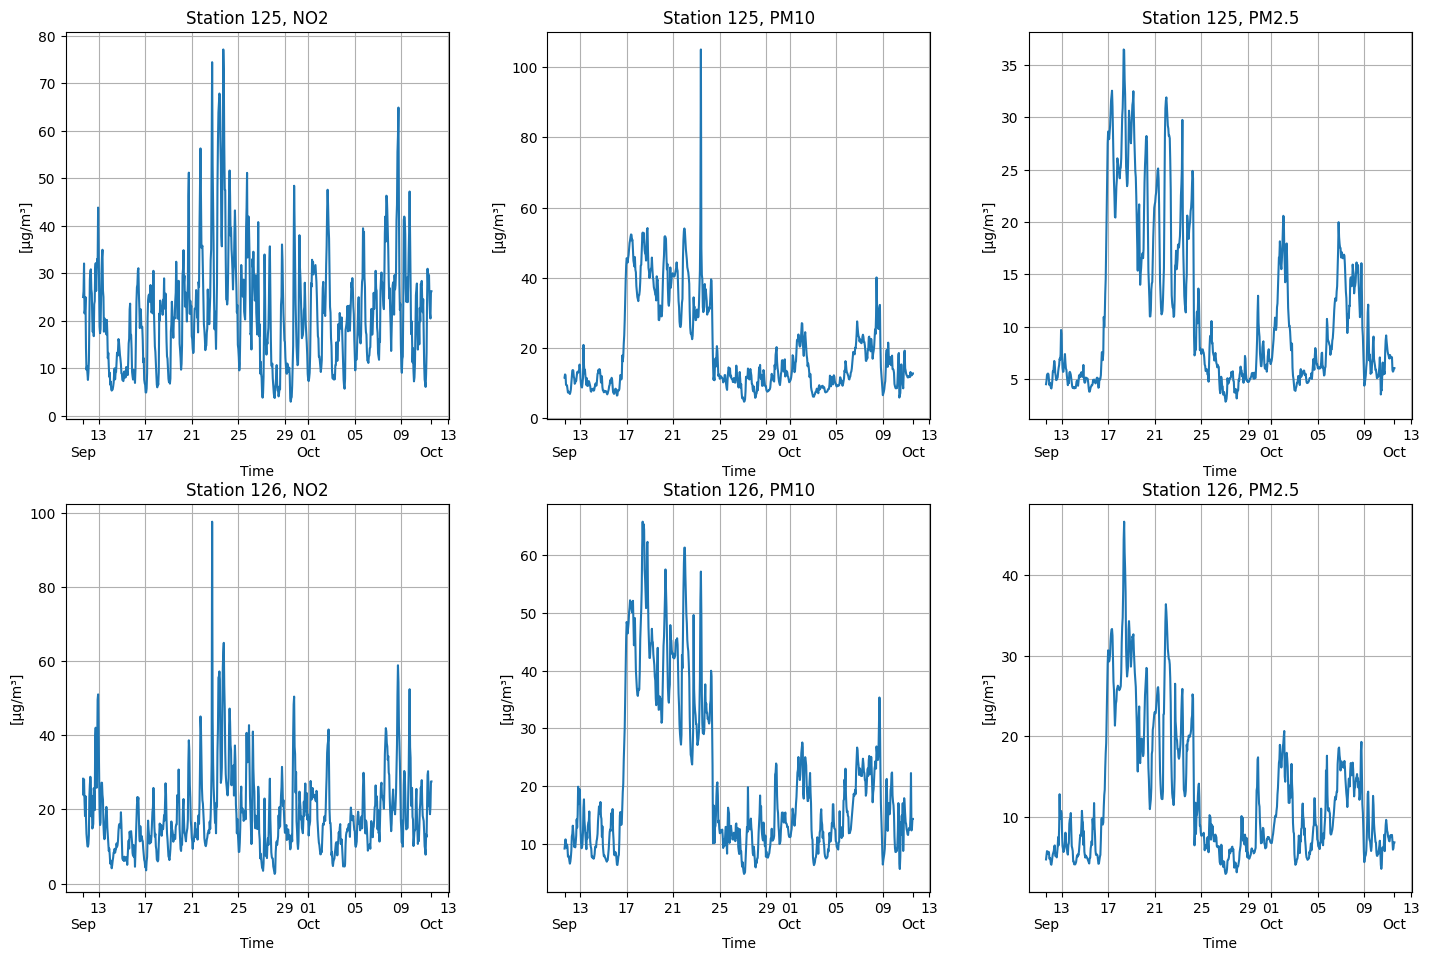

In [47]:
plot_pollution()
plt.show()

In [10]:
# anomaly replacement using interpolation method
for st in stations_id:
    for pol in pollutions:
        # replace the negative values with NaN
        dfs[st][pol]['Value'] = dfs[st][pol]['Value'].apply(lambda x: x if x > 0 else np.nan)
        dfs[st][pol]['Value'] = pd.to_numeric(dfs[st][pol]['Value'], errors='coerce').interpolate()

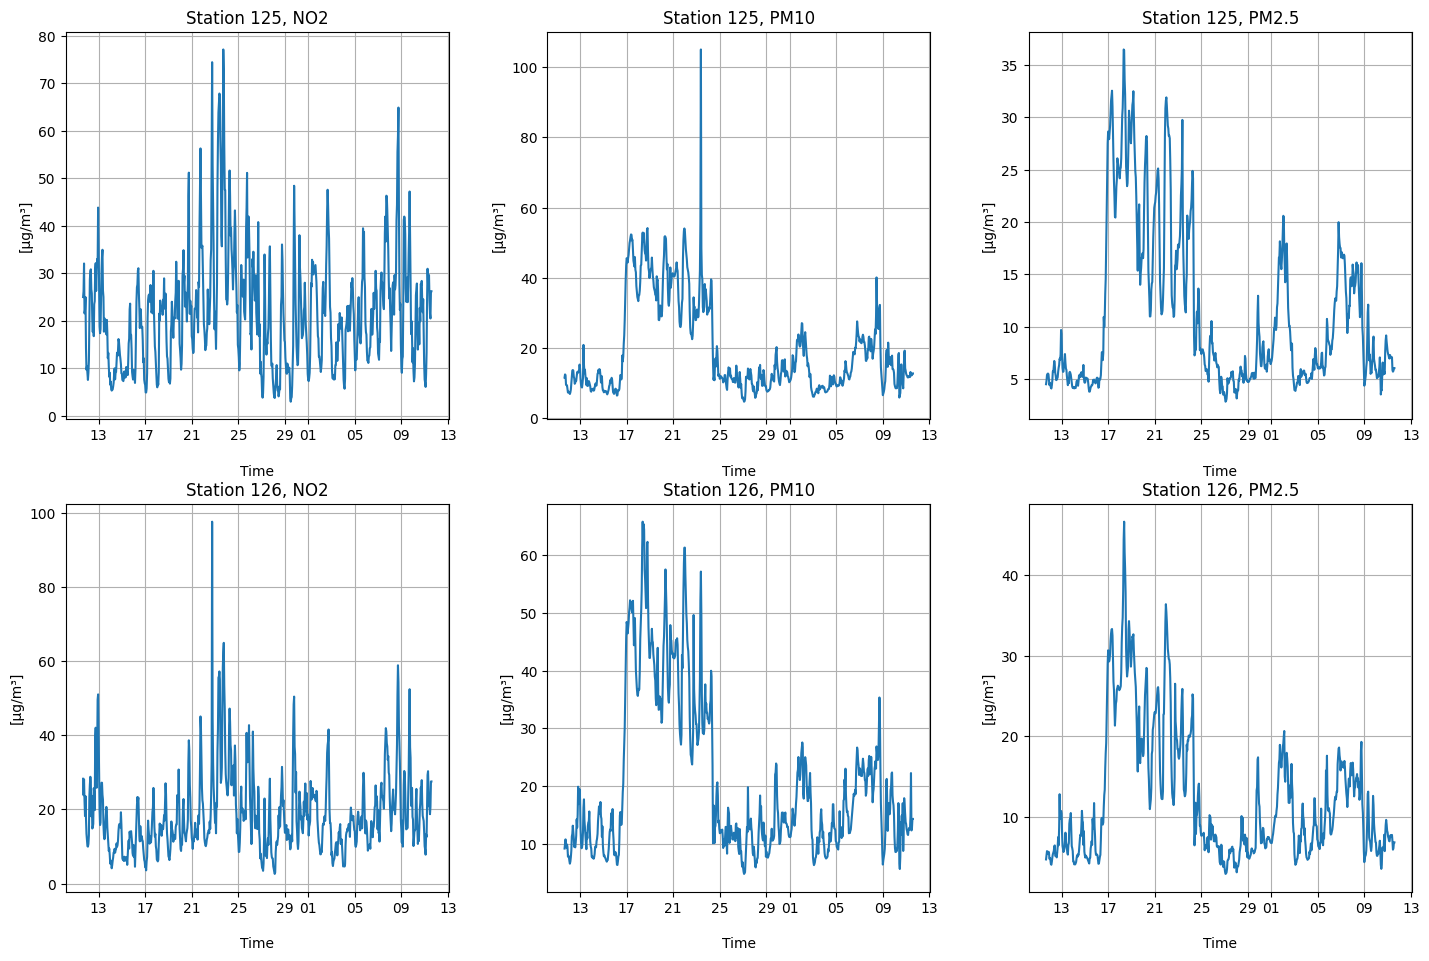

In [11]:
plot_pollution()
plt.show()

In [12]:
for st in stations_id:
    for pol in pollutions:
        print(len(dfs[st][pol]))

719
719
719
719
719
719


## Summary  Statistics

mean, median,  standard  deviation, variance,  minimum,  and maximum  etc.

In [13]:
def summary_statistics_plot():
    fig, axs = plot_pollution()

    for i, st in enumerate(stations_id):
        for j, pol in enumerate(pollutions):            
            mean = dfs[st][pol]['Value'].mean()
            median = dfs[st][pol]['Value'].median()
            standard_deviation = dfs[st][pol]['Value'].astype(float).std()
            variance = dfs[st][pol]['Value'].astype(float).var()
            minimum = dfs[st][pol]['Value'].min()               
            maximum = dfs[st][pol]['Value'].max()

            axs[i, j].text(0.7, 0.7, f'Mean: {mean:.2f}\nMedian: {median:.2f}\nStandard deviation: {standard_deviation:.2f}\nVariance: {variance:.2f}\nMin: {minimum:.2f}\nMax: {maximum:.2f}', horizontalalignment='center', verticalalignment='center', transform=axs[i, j].transAxes)


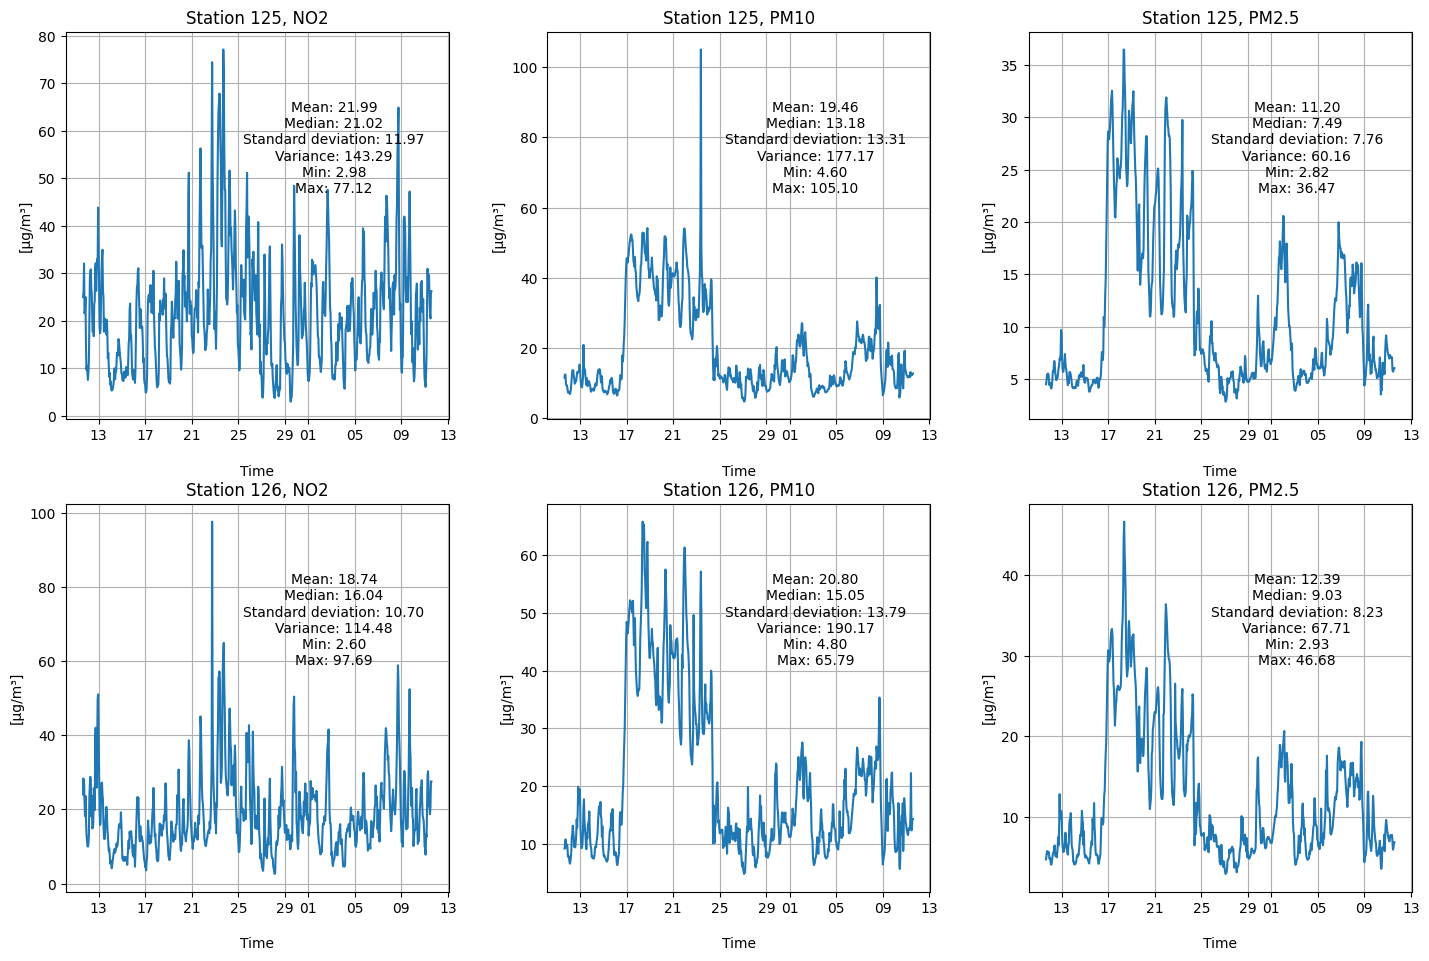

In [14]:
summary_statistics_plot()

## Time  Series  Plots

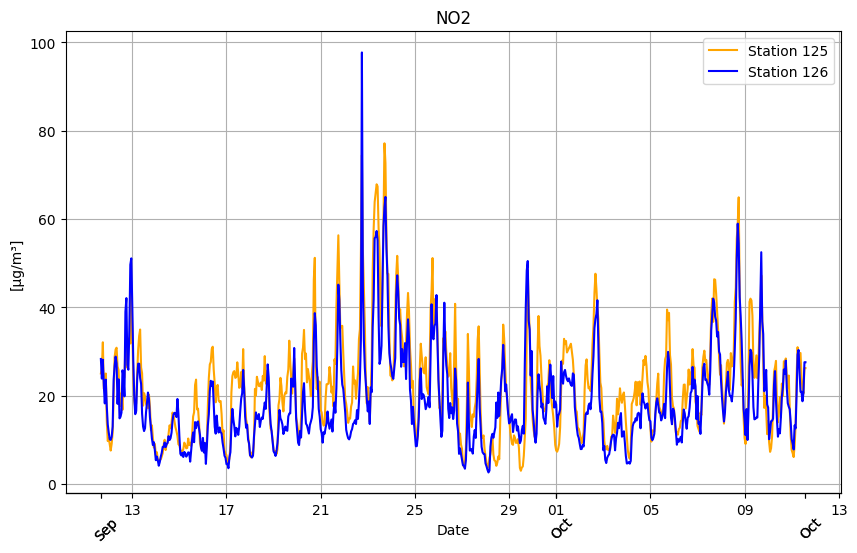

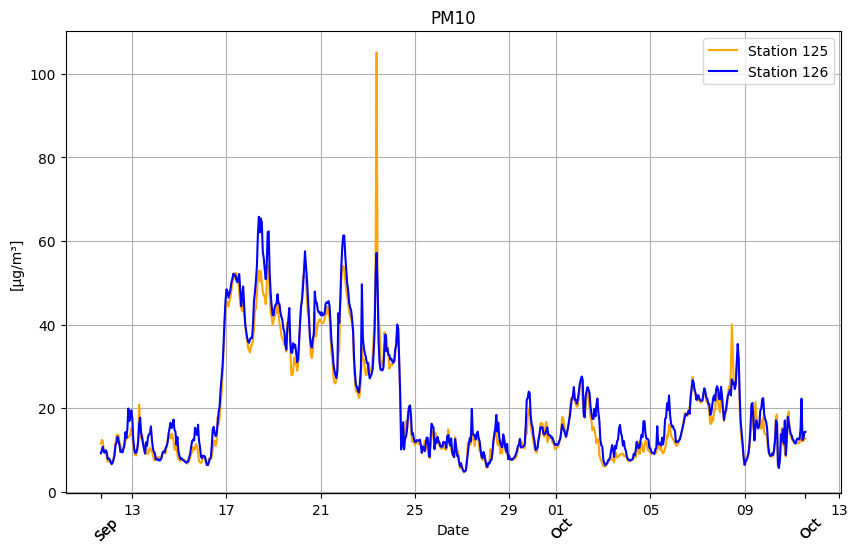

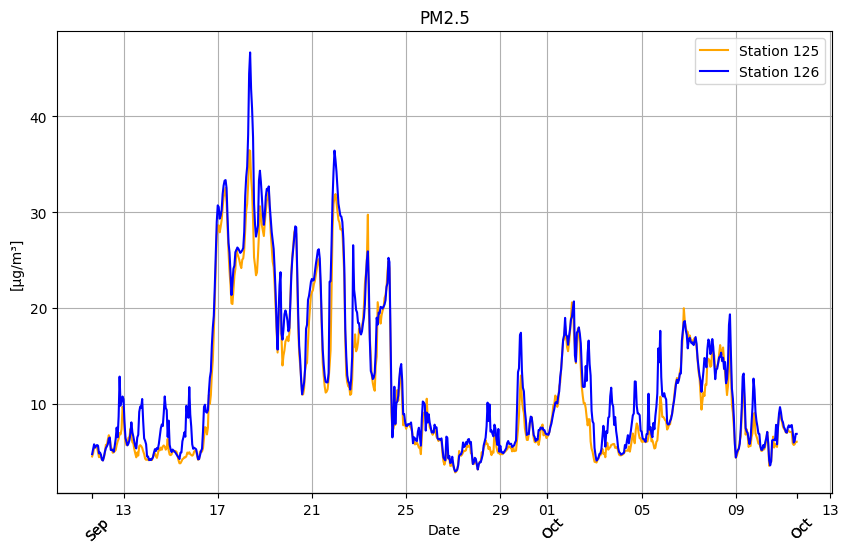

In [73]:
def time_series_plots():
    colors = ['orange', 'blue']

    for pol in pollutions:
        plt.figure(figsize=(10, 6))
        
        for st in stations_id:
            df = dfs[st][pol].copy()
            
            df['Start'] = pd.to_datetime(df['Start'])
            st_time = df['Start']
            df.set_index('Start', inplace=True)            

            plt.plot(df.index, df['Value'], label=f'Station {st}', color=colors[stations_id.index(st)])     

            # plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
            # plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=1))
            
            plt.xlabel('Date')
            plt.ylabel('[µg/m³]')
            plt.title(f'{pollution_name(pol)}')
            # plt.xticks(rotation=45, ha='right', fontsize=10)
            plt.legend(loc='best')

            plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%d'))
            sec_xticks = [st_time.iloc[0],*st_time[st_time.dt.is_month_start].dt.normalize().unique().tolist(), st_time.iloc[-1]]
            plt.gca().secondary_xaxis(location=0).set_xticks(sec_xticks, [f'\n{i:%b}' for i in sec_xticks], rotation=45)
        plt.grid(True)

        plt.show()


time_series_plots()

## Histograms

In [16]:
def histogram_plots():
    fig, axs = plt.subplots(2, 3, figsize=(15, 10)) 
    fig.tight_layout(pad=4.0) 

    for i, st in enumerate(stations_id):
        for j, pol in enumerate(pollutions):
            axs[i, j].hist(dfs[st][pol]['Value'], density=True, alpha=0.6, bins=100)
            axs[i, j].set_title(f'Station {st[-3:]}, {pollution_name(pol)}')
            axs[i, j].set_xlabel('[µg/m³]')
            axs[i, j].set_ylabel('Density')

            sns.kdeplot(dfs[st][pol]['Value'], ax=axs[i, j], color='red', linewidth=3, common_norm=False)

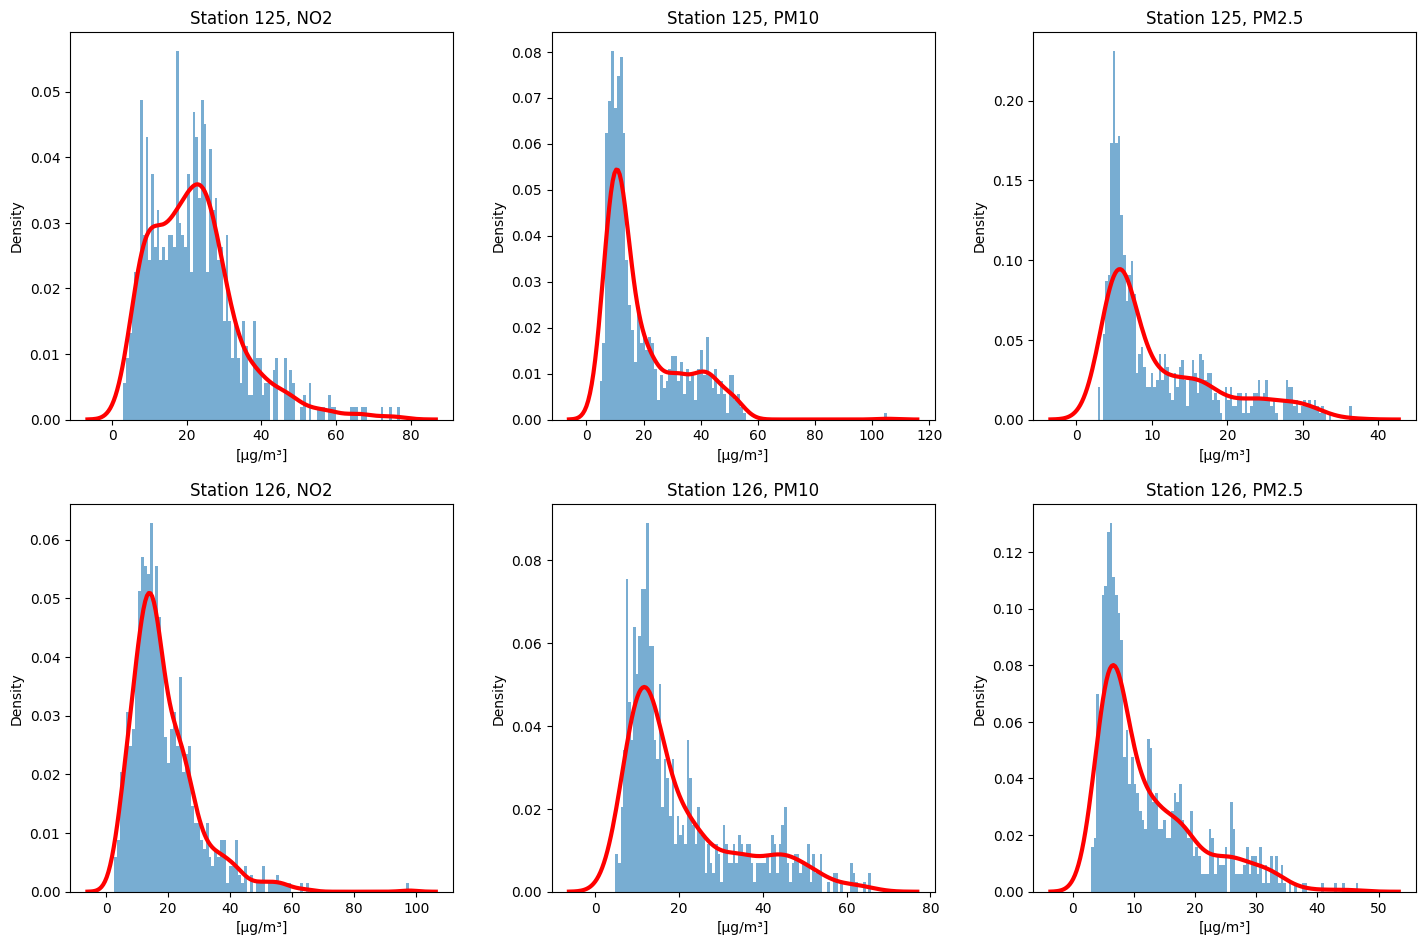

In [17]:
histogram_plots()

## Correlation Analysis

correlation  analysis  between  different  air  quality  parameters within  the  same station

In [18]:
def correlation_analysis_different_params():
    for st in stations_id:
        for pol in combinations(pollutions, 2):

            x_data = pd.to_numeric(dfs[st][pol[0]]['Value'], errors='coerce')
            y_data = pd.to_numeric(dfs[st][pol[1]]['Value'], errors='coerce')

            plt.figure(figsize=(8, 6))
            sns.scatterplot(x=dfs[st][pol[0]]['Value'], y=dfs[st][pol[1]]['Value'])
            sns.regplot(x=x_data, y=y_data, ci=95, line_kws={"color": "red"})
            plt.title(f'{pollution_name(pol[0])} vs {pollution_name(pol[1])} - Station {st[-3:]}')
            plt.xlabel(f'{pollution_name(pol[0])}')
            plt.ylabel(f'{pollution_name(pol[1])}')
            plt.show()
            
            correlation_coefficient, p_value = pearsonr(x_data, y_data)
            print(f'Correlation coefficient between {pollution_name(pol[0])} and {pollution_name(pol[1])}: {correlation_coefficient}')
            print(f'P-value: {p_value}')
            
            if p_value < 0.05:
                print('The correlation is statistically significant.')
            else:
                print('The correlation is not statistically significant.')


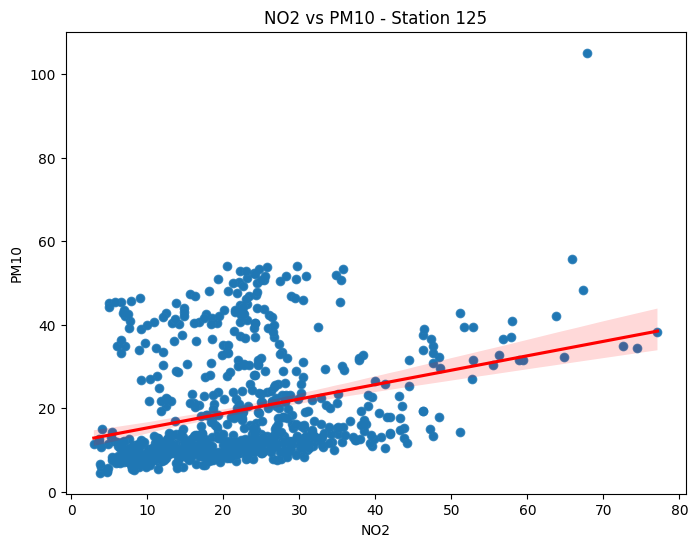

Correlation coefficient between NO2 and PM10: 0.31034201182513527
P-value: 1.619212655000087e-17
The correlation is statistically significant.


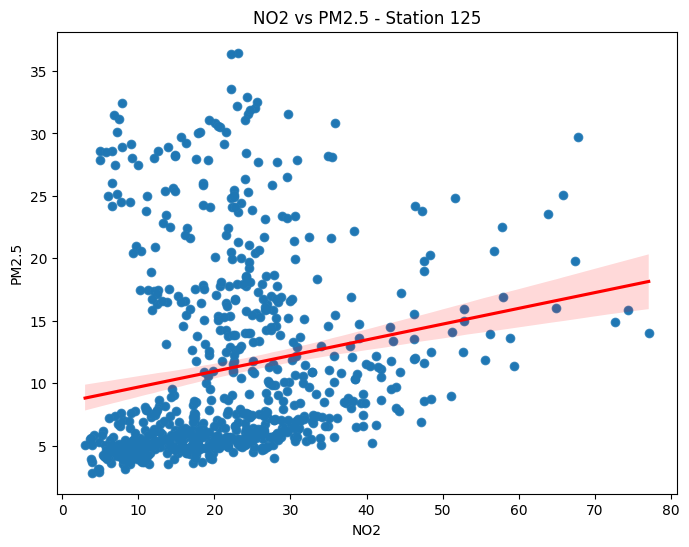

Correlation coefficient between NO2 and PM2.5: 0.19448969037697023
P-value: 1.46999399267122e-07
The correlation is statistically significant.


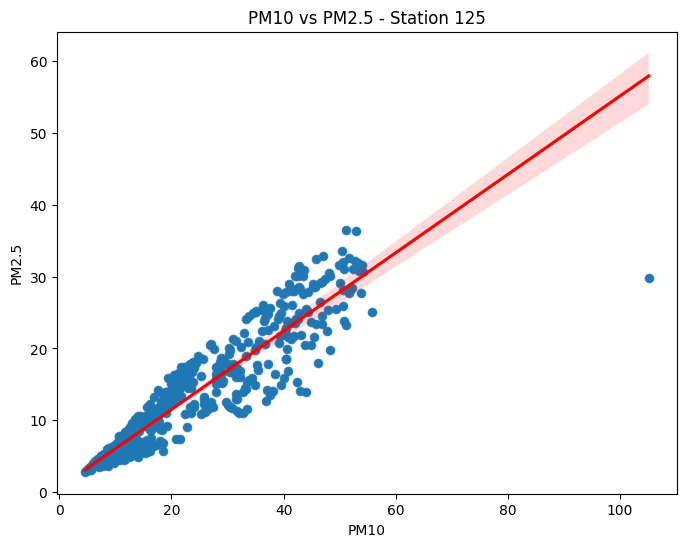

Correlation coefficient between PM10 and PM2.5: 0.9369157609067829
P-value: 0.0
The correlation is statistically significant.


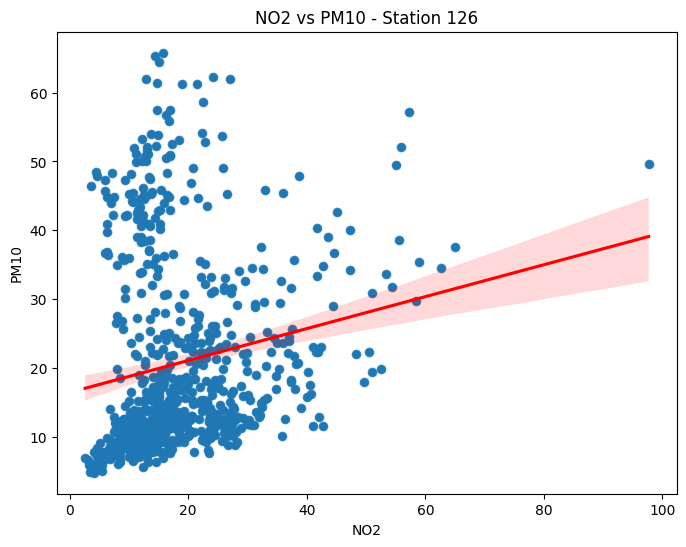

Correlation coefficient between NO2 and PM10: 0.17982918489874744
P-value: 1.2148565525461215e-06
The correlation is statistically significant.


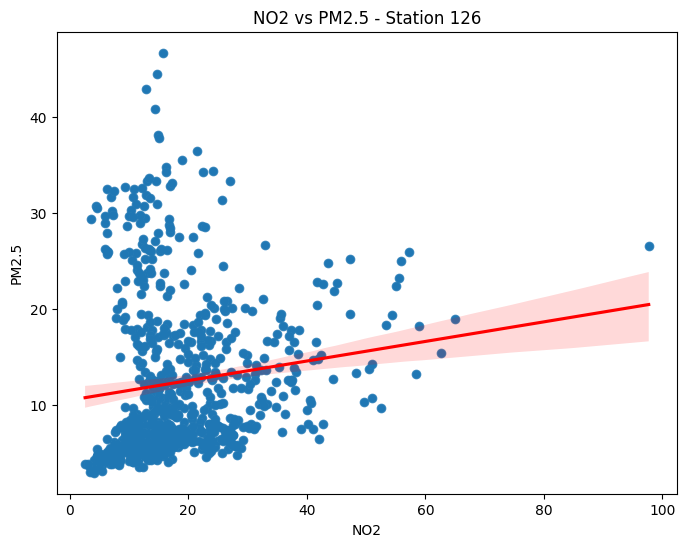

Correlation coefficient between NO2 and PM2.5: 0.13266761250986503
P-value: 0.00036114449581694207
The correlation is statistically significant.


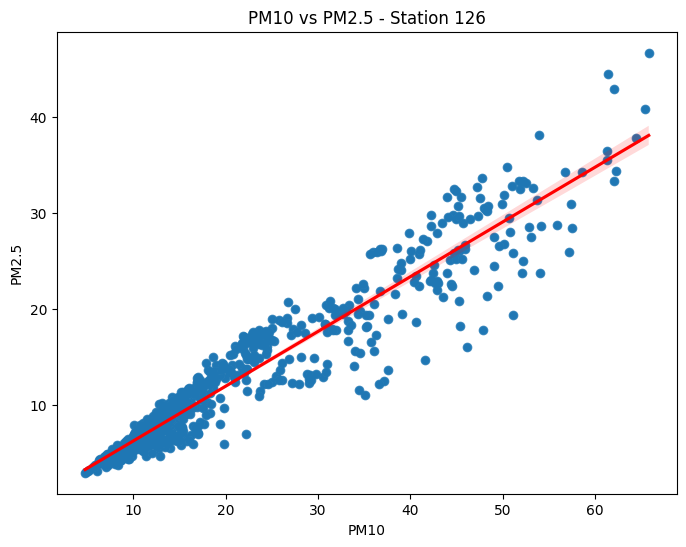

Correlation coefficient between PM10 and PM2.5: 0.9564067306855296
P-value: 0.0
The correlation is statistically significant.


In [19]:
correlation_analysis_different_params()

In [20]:
def correlation_analysis_different_stations():
    for pol in pollutions:
        x_data = dfs[stations_id[0]][pol]['Value']
        y_data = dfs[stations_id[1]][pol]['Value']

        plt.figure(figsize=(8, 6))
        sns.scatterplot(x=x_data, y=y_data)
        sns.regplot(x=x_data, y=y_data, ci=95, line_kws={"color": "red"})
        plt.title(f'station {stations_id[0]} vs {stations_id[1]} - {pollution_name(pol)}')
        plt.xlabel(f'station {stations_id[0]}')
        plt.ylabel(f'station {stations_id[1]}')
        plt.show()
        
        correlation_coefficient, p_value = pearsonr(x_data, y_data)
        print(f'Correlation coefficient between {pollution_name(pol[0])} and {pollution_name(pol[1])}: {correlation_coefficient}')
        print(f'P-value: {p_value}')
        
        if p_value < 0.05:
                print('The correlation is statistically significant.')
        else:
            print('The correlation is not statistically significant.')

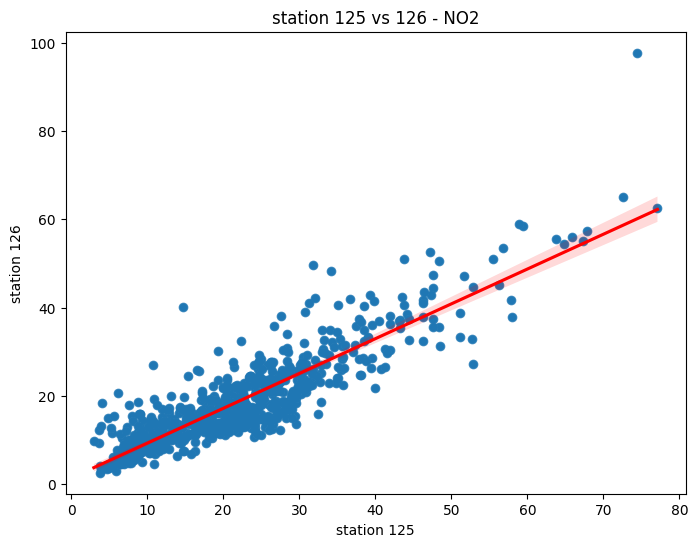

Correlation coefficient between None and None: 0.8821305108364673
P-value: 1.2236481638434159e-236
The correlation is statistically significant.


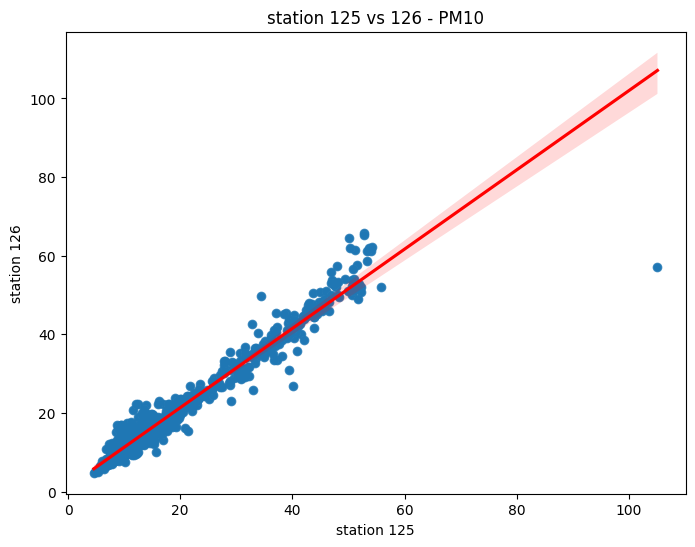

Correlation coefficient between None and None: 0.9728503238391462
P-value: 0.0
The correlation is statistically significant.


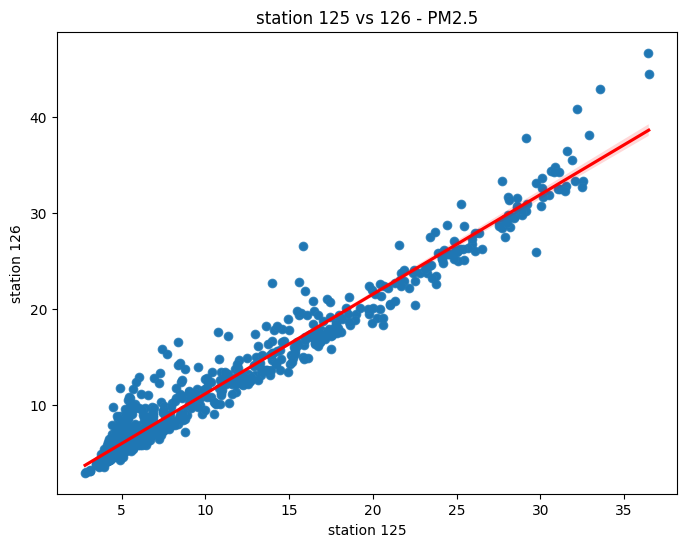

Correlation coefficient between None and None: 0.9778048324081304
P-value: 0.0
The correlation is statistically significant.


In [21]:
correlation_analysis_different_stations()

## Trend Analysis

Linear regression analysis
Slope: -0.1889215588335207, P-value: 1.1140457487725309e-08


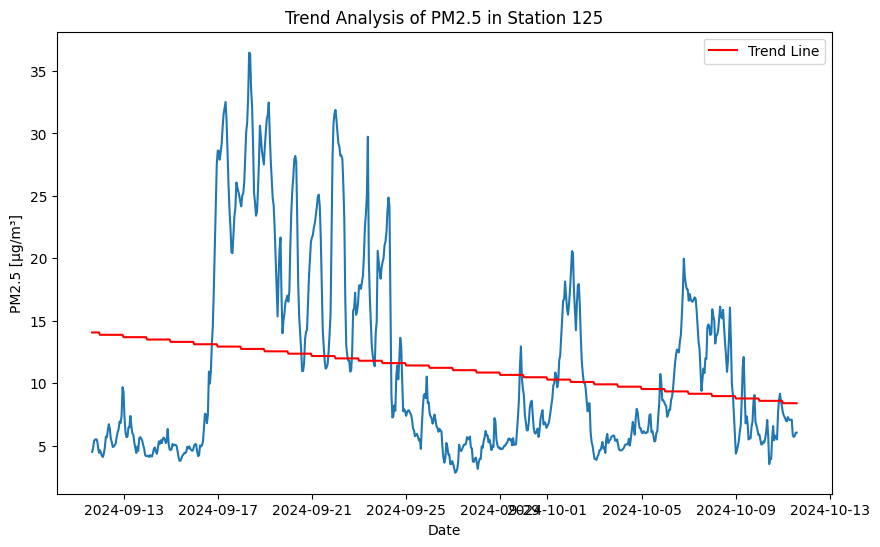

In [22]:
df = dfs['125']['PM2'].copy()

df['Start'] = pd.to_datetime(df['Start'])
df.set_index('Start', inplace=True)
df['ordinal_date'] = df.index.map(pd.Timestamp.toordinal)       # for slope calculation

# Linear regression
slope, intercept, r_value, p_value, std_err = linregress(df['ordinal_date'], df['Value'])
print(f'Linear regression analysis')
print(f"Slope: {slope}, P-value: {p_value}")

plt.figure(figsize=(10,6))
sns.lineplot(x=df.index, y=df['Value'])

plt.plot(df.index, slope * df['ordinal_date'] + intercept, color='red', label='Trend Line')
plt.title('Trend Analysis of PM2.5 in Station 125')
plt.xlabel('Date')
plt.ylabel('PM2.5 [µg/m³]')
plt.legend()
plt.show()

Linear regression analysis
Slope: 0.11446683654504398, P-value: 0.02634136716322504


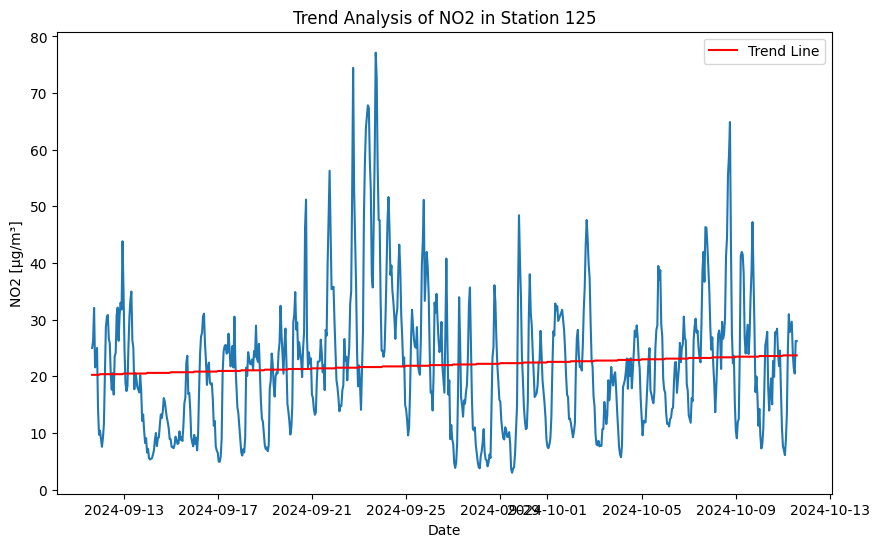

In [23]:
df = dfs['125']['NO2'].copy()

df['Start'] = pd.to_datetime(df['Start'])
df.set_index('Start', inplace=True)
df['ordinal_date'] = df.index.map(pd.Timestamp.toordinal)       # for slope calculation

# Linear regression
slope, intercept, r_value, p_value, std_err = linregress(df['ordinal_date'], df['Value'])
print(f'Linear regression analysis')
print(f"Slope: {slope}, P-value: {p_value}")

plt.figure(figsize=(10,6))
sns.lineplot(x=df.index, y=df['Value'])

plt.plot(df.index, slope * df['ordinal_date'] + intercept, color='red', label='Trend Line')
plt.title('Trend Analysis of NO2 in Station 125')
plt.xlabel('Date')
plt.ylabel('NO2 [µg/m³]')
plt.legend()
plt.show()